# Implementation of Perelson et al.

In this implementation we're going to implement a [dynamical model](http://science.sciencemag.org/content/271/5255/1582), and evaluate it's properties.

In [1]:
% matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import least_squares

# 104, 105, 107
V0 = np.array([52., 643., 77.])*1.0e3
c = np.array([3.68, 2.06, 3.09])
delta = np.array([0.5, 0.53, 0.5])
Ttot = np.array([2., 11., 412.])*1.0e3
tdelay = np.array([2., 6., 2.])/24.

k = 3.43e-8
t = np.linspace(0, 8, 1000)

### (1) Reproduce all four panels from Figure 1 shown in Perelson et al. using eq. 6

Since we are not given any empirical data, use the fitted parameters and the appropriate constants to generate the curves shown on these plots. Remember to account for the time delays for each patient.

#### (i) Implement eq. 6 from the paper as a function.

In [2]:
def v_t(V0, c, t, delta):
    exp_ct = np.exp(-c*t)
    c_frac = c/(c-delta)
    
    return V0*exp_ct + V0*c_frac*(c_frac*(np.exp(-delta*t) - exp_ct) - delta*t*exp_ct)

#### (ii) Make the plot from this function's values over time.

Note that some constants are given in other papers published by this lab. An estimate of k, the viral infectivity rate, can be found in Wein et al. (J. Theor. Biol. 192:81-98) to be $3.43\times10^{-8}$ mL/(virion•day). Note that you will need to solve ordinary differential equations for T*, VI, and VNI to reproduce the data in Figure 1.

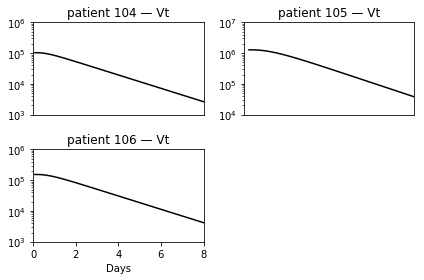

In [3]:
for ii in range(3):
    plt.subplot(221 + ii);
    # each virion corresponds to 2 RNA copies
    plt.semilogy(t + tdelay[ii],2*v_t(V0[ii], c[ii], t, delta[ii]), 'k');
    plt.xlim(0, 8);
    plt.ylim(np.power(10, 3 + ii%2), np.power(10, 6 + ii%2));
    plt.title('patient ' + str(104 + ii) + ' — Vt');
    
    if ii < 2:
        plt.xticks([])
        
plt.xlabel('Days')

plt.tight_layout();

### (2) Reimplement the model relaxing the assumption about T remaining constant by numerically solving the system of ODEs.

#### i. Define a function that takes each parameter as a vector and outputs the time derivative of each species.

In [4]:
# after drug treatment
def diffEqs(y0, t, k, c, N, delta, T_tot, eta):
    T_star, V_I, V_NI = y0
    
    return np.array([k * V_I * (T_tot - T_star) - delta * T_star,
                     N * delta * T_star * (1-eta) - c * V_I,
                     N * delta * T_star * eta - c * V_NI])

#### ii. Use odeint to solve this system of equations numerically for patient 105.

Hint: For ease later, it may be helpful to make a function here that handles everything but takes in $\eta$.

In [5]:
def initState(V0in, cin, deltain, TtotIn):
    T = TtotIn / (1 + ((k * V0in) / deltain))
    Ts = (k * V0in * T) / deltain
    Nout = (cin * V0in) / (deltain * Ts)
    
    return (np.array([Ts, V0in, 0.0]), Nout, T)

def solveNum(V0in, cin, deltain, TtotIn, t, eta=1):
    y0, N, T = initState(V0in, cin, deltain, TtotIn)

    return odeint(diffEqs, y0, t, args=(k, cin, N, deltain, TtotIn, eta))

prod = solveNum(V0[1], c[1], delta[1], Ttot[1], t)

#### iii. Reproduce the subpanels of Fig. 1 with this updated model.

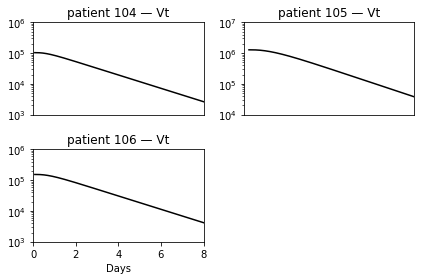

In [6]:
for ii in range(3):
    plt.subplot(221 + ii);
    dOut = solveNum(V0[ii], c[ii], delta[ii], Ttot[ii], t)
    # each virion corresponds to 2 RNA copies
    plt.semilogy(t + tdelay[ii], 2*(dOut[:, 1] + dOut[:, 2]), 'k');
    plt.xlim(0, 8);
    plt.ylim(np.power(10, 3 + ii%2), np.power(10, 6 + ii%2));
    plt.title('patient ' + str(104 + ii) + ' — Vt');
    
    if ii < 2:
        plt.xticks([])
        
plt.xlabel('Days')

plt.tight_layout();

#### iv. Are the results the same as in (1)?

Show evidence of your conclusion.

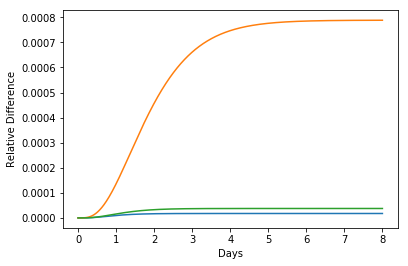

In [7]:
def relDiff(V0in, cin, deltain, TtotIn, t):
    dSol = solveNum(V0in, cin, deltain, TtotIn, t)
    
    Vnum = dSol[:, 1] + dSol[:, 2]
    
    iSol = v_t(V0in, cin, t, deltain)
    
    return (Vnum - iSol) / (Vnum + iSol)

for ii in range(3):
    plt.plot(t, relDiff(V0[ii], c[ii], delta[ii], Ttot[ii], t));

plt.ylabel('Relative Difference');
plt.xlabel('Days');

### (3) Repeat the work that the authors describe in item 12 of their “References and Notes”.

#### (i) Namely, vary the effectiveness factor of the drug (η=1.0, 0.99, 0.95, and 0.90) and simulate the viral load that would result from the modified differential equations using the parameters c=3.0 days-1 and δ=0.5 days-1 as described in item 12 and the values of T0, V0, and the time delay provided for patient 105.

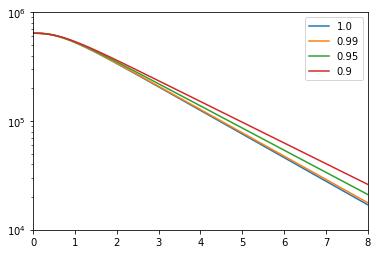

In [8]:
eta = np.array([1.0, 0.99, 0.95, 0.90])

for ii, eCur in enumerate(eta):
    nSol = solveNum(V0[1], 3.0, 0.5, Ttot[1], t, eCur)
    
    plt.semilogy(t, nSol[:, 1] + nSol[:, 2])

plt.xlim(0, 8);
plt.ylim(1.0e4, 1.0e6);
plt.legend(eta);

#### (ii) Then, use the function scipy.optimize.leastsq to fit this data to the equation for V(t) given in the paper and find the estimates of c and δ that result. Fit only the portion of the curve after the pharmacokinetic delay. Compare these estimates to the actual values for c and δ and discuss the consequences of an imperfect drug on clearance time estimates.

In [9]:
# Don't need to account for time delay here, because both models are shifted the same

data = np.sum(solveNum(V0[1], 3.0, 0.5, Ttot[1], t)[:, 1::], axis=1)

def residual(xx, eta, V0in, TtotIn):
    nSol = np.sum(solveNum(V0in, xx[0], xx[1], TtotIn, t, eta)[:, 1::], axis=1)
    
    return np.log10(data / nSol) # Given data assume log-normal


lsqSol = np.zeros((4, 2))
residV = np.zeros((4, t.size))

for ii, eCur in enumerate(eta):
    result = least_squares(residual,
                           x0 = np.array([3.0, 0.5]),
                           args=(eCur, V0[1], Ttot[1]),
                           jac='3-point',
                           bounds=([0, 0], [10, 5]))

    lsqSol[ii, :] = result['x']
    residV[ii, :] = result['fun']

print(lsqSol)

[[3.         0.5       ]
 [2.99516648 0.50629772]
 [2.9751892  0.53314544]
 [2.94857421 0.5709692 ]]


#### (iii) Examine the residual plots from your fits to determine whether or not there is a trend in the error associated with fitting these new curves.

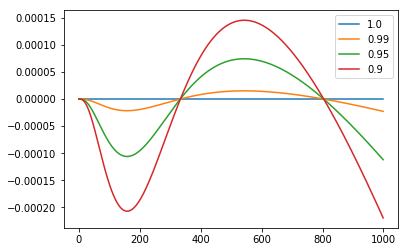

In [10]:
plt.plot(np.transpose(residV));
plt.legend(eta);

### (4) To determine the TCID50 one should estimate an infectivity coefficient.

To calculate the infectivity coefficient, estimate the ratio of VI(t=0) to the value of TCID50(t=0) for patient 105 from Perelson’s Figure 1. This coefficient acts as a conversion factor between the number of virions in the infectious pool, VI, and the TCID50, and is an indicator of the efficiency of the HIV-1 transmission.

535.8333333333334


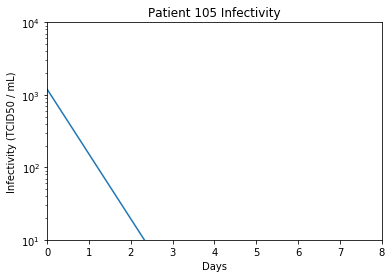

In [11]:
coefficient = prod[0, 1] / 1.2e3
print(coefficient)

plt.semilogy(t, prod[:, 1] / coefficient);
plt.ylim(1e1, 1e4);
plt.xlim(0, 8);
plt.ylabel('Infectivity (TCID50 / mL)');
plt.xlabel('Days');
plt.title('Patient 105 Infectivity');